### The correlation of observed precipitation data with dry spells
This notebook explores the correlation between observed precipitation and dry spells. 
The goal of the analysis is to see if, given perfect forecasting skill, there is information in the forecasted quantities for forecasting dryspells.
This notebook focuses on the observation of below average seasonal precipitation. Monthly below average will be added later.
For the seasonal precipitation as well as for the dry spells, CHIRPS is used as data source. The occurence of seasonal below average precipitation is computed in `mwi_obsprecip.ipynb`, and the dry spells are computed in `mwi_chirps_dry_spell_detection.R`

The first part of this notebook explores the characteristics of the dry spells and seasonal precipitation, and looks at correlations between the sole occurence of a dry spell and below average precipitation in an admin2. The latter part looks at the number of admin2's within the country experiencing below average precipitation/dry spells.


Questions
- Is the code to aggregate dry spells to seasons correct? 
- Do you agree with the methodology to aggregate dry spells to seasons or would do it differently?
- Is there an analysis I am missing?
- Would you say that based on the current analysis it is valid to conclude that there is no signal in below average seasonal rainfall to predict dry spells?

### set general variables and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


#### Set config values

In [4]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [5]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Load dry spell data

In [6]:
df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","dry_spells_during_rainy_season_list_2000_2020_mean.csv")) 
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["ds_fd_m"]=df_ds.dry_spell_first_date.dt.to_period("M")

In [7]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,ds_fd_m
0,MW101,Chitipa,2008,2009-04-07,2009-05-03,27,1.8,Northern,2009-04
1,MW103,Nkhata Bay,2001,2002-04-19,2002-05-19,31,3.4,Northern,2002-04
2,MW103,Nkhata Bay,2008,2009-04-06,2009-05-03,28,1.7,Northern,2009-04
3,MW104,Rumphi,2005,2006-04-17,2006-04-30,14,0.1,Northern,2006-04
4,MW105,Mzimba,2005,2006-04-17,2006-05-15,29,2.0,Northern,2006-04
...,...,...,...,...,...,...,...,...,...
127,MW315,Blantyre City,2001,2002-03-24,2002-04-06,14,0.0,Southern,2002-03
128,MW315,Blantyre City,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008-02
129,MW315,Blantyre City,2008,2009-04-04,2009-05-03,30,0.0,Southern,2009-04
130,MW315,Blantyre City,2014,2015-04-01,2015-04-15,15,2.0,Southern,2015-04


In [8]:
#compute if start of dryspell per month-ADM2
#for now only want to know if a dry spell occured in a given month, so drop those that have several dry spells confirmed within a month
df_ds_drymonth=df_ds.drop_duplicates(["ADM2_EN","ds_fd_m"]).groupby(["ds_fd_m","ADM2_EN"],as_index=False).agg("count")[["ds_fd_m","ADM2_EN","dry_spell_first_date"]]

#### Load historical seasonal below average rainfall
And remove seasons outside the rainy season    

In [9]:
df_belowavg_seas=pd.read_csv(os.path.join(country_data_processed_dir,"observed_belowavg_precip","chirps_seasonal_below_average_precipitation.csv"))
#remove day part of date (day doesnt indicate anything with this data and easier for merge)
df_belowavg_seas.date_month=pd.to_datetime(df_belowavg_seas.date_month).dt.to_period("M")

In [58]:
#path to data start and end rainy season
df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020_mean.csv"))
df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [59]:
#set the onset and cessation date for the seasons where these are missing 
#(meaning there was no dry spell data from start/till end of the season)
df_rain_filled=df_rain.copy()
df_rain_filled=df_rain_filled[(df_rain_filled.onset_date.notnull())|(df_rain_filled.cessation_date.notnull())]
df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

In [60]:
df_rain_filled["onset_month"]=df_rain_filled["onset_date"].dt.to_period("M")
df_rain_filled["cessation_month"]=df_rain_filled["cessation_date"].dt.to_period("M")

In [61]:
#remove the adm2-date entries outside the rainy season for that specific adm2
#df_belowavg_seas only includes data from 2000, so the 1999 entries are not included
list_hist_rain_adm2=[]
for a in df_rain_filled.ADM2_EN.unique():
    dates_adm2=pd.Index([])
    for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
        df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
        seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="M")
        dates_adm2=dates_adm2.union(seas_range)
    list_hist_rain_adm2.append(df_belowavg_seas[(df_belowavg_seas.ADM2_EN==a)&(df_belowavg_seas.date_month.isin(dates_adm2))])
df_belowavg_seas_rain=pd.concat(list_hist_rain_adm2)

### Merge dry spells with Seasonal below average rainfall
**NOTE: we currently only include the season (3-month period) if all months are within the rainy season. E.g. if the rainy season ends in April for an admin2, MAM will not be included for that admin2**

In [62]:
#include all dates present in the observed rainfall df but not in the dry spell list, i.e. where no dryspells were observed, by merging outer
df_ds_drymonth_rain=df_ds_drymonth.merge(df_belowavg_seas_rain[["ADM2_EN","date_month"]],how="outer",left_on=['ADM2_EN','ds_fd_m'],right_on=["ADM2_EN","date_month"])

In [63]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_ds_drymonth_rain.dry_spell_first_date=df_ds_drymonth_rain.dry_spell_first_date.replace(np.nan,0)

In [64]:
#fill the data frame to include all months, also outside the rainy season --> this enables us to take the rolling sum 
#(else e.g. the rolling sum for Nov might include May-June-Nov)
df_ds_drymonth_alldates=df_ds_drymonth_rain.sort_values("date_month").set_index("date_month").groupby('ADM2_EN').resample('M').sum().drop("ADM2_EN",axis=1).reset_index()

In [65]:
df_ds_drymonth_alldates[df_ds_drymonth_alldates.ADM2_EN=="Balaka"].date_month.unique()

<PeriodArray>
['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
 '2000-08', '2000-09', '2000-10',
 ...
 '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
 '2020-01', '2020-02', '2020-03']
Length: 243, dtype: period[M]

In [66]:
#number of entries with dry spell
len(df_ds_drymonth_alldates[df_ds_drymonth_alldates.dry_spell_first_date==1])

131

In [67]:
#compute the rolling sum of months having a dry spell per admin2
s_ds_dryseas=df_ds_drymonth_alldates.sort_values("date_month").set_index("date_month").groupby('ADM2_EN')['dry_spell_first_date'].rolling(3).sum()
#convert series to dataframe
df_ds_dryseas=pd.DataFrame(s_ds_dryseas).reset_index().sort_values(["ADM2_EN","date_month"])
df_ds_dryseas.rename(columns={"dry_spell_first_date":"num_dry_spell_seas"},inplace=True)

<AxesSubplot:xlabel='num_dry_spell_seas', ylabel='Count'>

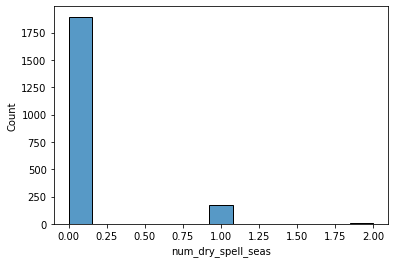

In [68]:
#never occured that two or three consecutive months in same adm2 experienced a dry spell..
sns.histplot(df_ds_dryseas,x="num_dry_spell_seas")

In [69]:
df_ds_dryseas

,ADM2_EN,date_month,num_dry_spell_seas
0,Balaka,2000-01,NaN
1,Balaka,2000-02,NaN
2,Balaka,2000-03,0.0
3,Balaka,2000-04,0.0
4,Balaka,2000-05,NaN
...,...,...,...
7923,Zomba City,2020-08,NaN
7924,Zomba City,2020-09,NaN
7925,Zomba City,2020-10,NaN
7926,Zomba City,2020-11,NaN


In [70]:
#merge the dry spells with the info if a month had below average rainfall
#merge on right such that only the dates within the rainy season are included, df_ds_dryseas also includes all other months
df_comb_seas=df_ds_dryseas.merge(df_belowavg_seas_rain,how="right",on=["date_month","ADM2_EN"])

In [71]:
df_comb_seas

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,validOn,validTo,perc_threshold,perc_threshold_touched,max_cell_touched,max_cell,below_average_touched,below_average_max,date_str,below_average
0,Chitipa,2000-01,NaN,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,100.000000,100.000000,386.170864,386.170864,1,1,2000-01,1
1,Chitipa,2000-02,NaN,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,100.000000,100.000000,505.818405,505.818405,1,1,2000-02,1
2,Chitipa,2000-03,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,100.000000,100.000000,675.228027,665.144302,1,1,2000-03,1
3,Chitipa,2000-04,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,60.431655,61.306533,756.143036,727.771973,1,1,2000-04,1
4,Chitipa,2000-11,NaN,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2000-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,Blantyre City,2019-12,NaN,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,100.000000,100.000000,237.336824,232.649269,1,1,2019-12,1
3432,Blantyre City,2020-01,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2020-01,0
3433,Blantyre City,2020-02,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.000000,11.764706,563.777794,-999.000000,1,0,2020-02,0
3434,Blantyre City,2020-03,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,100.000000,100.000000,563.488132,563.488132,1,1,2020-03,1


In [72]:
#remove dates where dry_spell_confirmation is nan, i.e. where rolling sum could not be computed for (first dates)
df_comb_seas=df_comb_seas[df_comb_seas.num_dry_spell_seas.notna()]

In [73]:
#set the occurence of a dry spell to true if in at least one of the months of the season (=3 months) a dry spell occured
df_comb_seas["dry_spell"]=np.where(df_comb_seas.num_dry_spell_seas>=1,1,0)

<ipython-input-73-9d6e10e58a0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_seas["dry_spell"]=np.where(df_comb_seas.num_dry_spell_seas>=1,1,0)


In [74]:
#seasons-adm2s where during at least one of the months a dry spell occured
len(df_comb_seas[df_comb_seas.dry_spell==1])

181

In [75]:
df_comb_seas

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,validTo,perc_threshold,perc_threshold_touched,max_cell_touched,max_cell,below_average_touched,below_average_max,date_str,below_average,dry_spell
2,Chitipa,2000-03,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,NaN,100.000000,100.000000,675.228027,665.144302,1,1,2000-03,1,0
3,Chitipa,2000-04,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,NaN,60.431655,61.306533,756.143036,727.771973,1,1,2000-04,1,0
6,Chitipa,2001-01,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2001-01,0,0
7,Chitipa,2001-02,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2001-02,0,0
8,Chitipa,2001-03,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,NaN,51.798561,49.748744,718.323776,718.323776,1,1,2001-03,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,Blantyre City,2019-03,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2019-03,0,0
3429,Blantyre City,2019-04,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2019-04,0,0
3432,Blantyre City,2020-01,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2020-01,0,0
3433,Blantyre City,2020-02,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,NaN,0.000000,11.764706,563.777794,-999.000000,1,0,2020-02,0,1


#### Analyse distributions below average rainfall and dry spells
There is barely a difference in the distribution of the percentage with below average rainfall when a dry spell occurs or not --> really not possible to separate the two..

Text(0.5, 0, 'Percentage of area of ADM2 with below average seasonal precipitation')

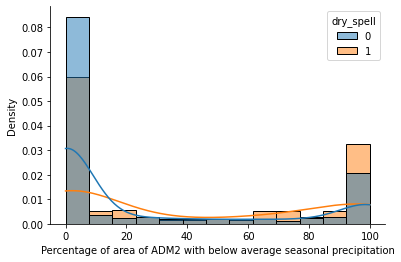

In [76]:
#perc_threshold indicates the percentage of area with below average rainfall per admin2-date combination
g=sns.histplot(df_comb_seas,x="perc_threshold",stat="density",common_norm=False,kde=True,hue="dry_spell")
g.axes.spines['right'].set_visible(False)
g.axes.spines['top'].set_visible(False)
g.axes.set_xlabel("Percentage of area of ADM2 with below average seasonal precipitation")

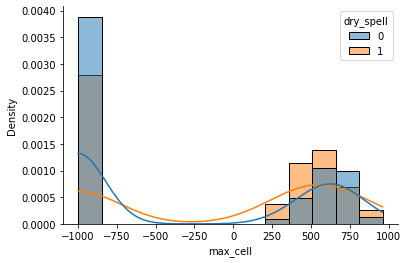

In [77]:
#max_cell indicates the cell per adm2-date combination with the maximum value
#however, all cells with above average rainfall are set to -999 
#--> if max cell is positive, all cells in the adm2 have below average rainfall
g=sns.histplot(df_comb_seas,x="max_cell",stat="density",common_norm=False,kde=True,hue="dry_spell")
g.axes.spines['right'].set_visible(False)
g.axes.spines['top'].set_visible(False)

#### Correlations
Not really any correlation, but is to be expected from the distributions

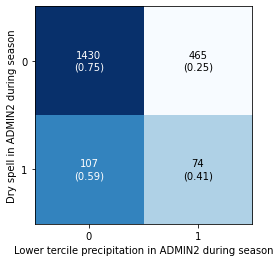

In [78]:
y_target =    df_comb_seas["dry_spell"]
#below_average is defined as perc_threshold>=50 where perc_threshold indicates the percentage of area with below average rainfall
y_predicted = df_comb_seas["below_average"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
# print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during season")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
plt.show()

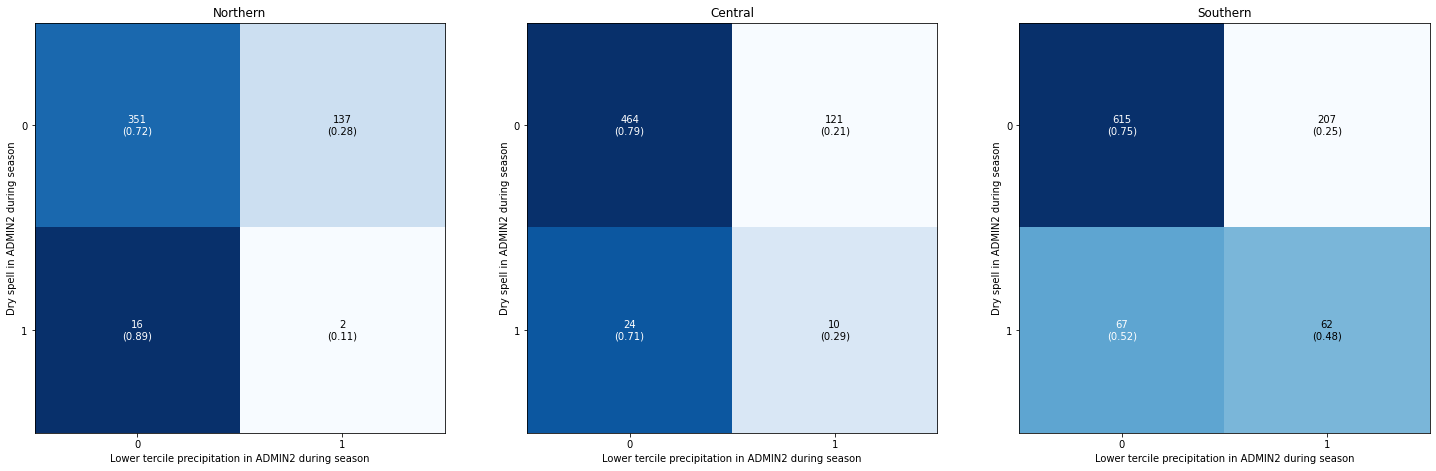

In [79]:
#check if difference per admin1
colp_num=3
num_plots=len(df_comb_seas.ADM1_EN.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,m in enumerate(df_comb_seas.ADM1_EN.unique()):
    y_target =    df_comb_seas.loc[df_comb_seas.ADM1_EN==m,"dry_spell"]
    y_predicted = df_comb_seas.loc[df_comb_seas.ADM1_EN==m,"below_average"]
    
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    ax = fig.add_subplot(rows,colp_num,i+1)
    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax)
    ax.set_ylabel("Dry spell in ADMIN2 during season")
    ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
    ax.set_title(m)

In [80]:
#mapping of month to season. Computed by rolling sum, i.e. month indicates last month of season
seasons_rolling={3:"JFM",4:"FMA",5:"MAM",6:"AMJ",7:"MJJ",8:"JJA",9:"JAS",10:"ASO",11:"SON",12:"OND",1:"NDJ",2:"DJF"}

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


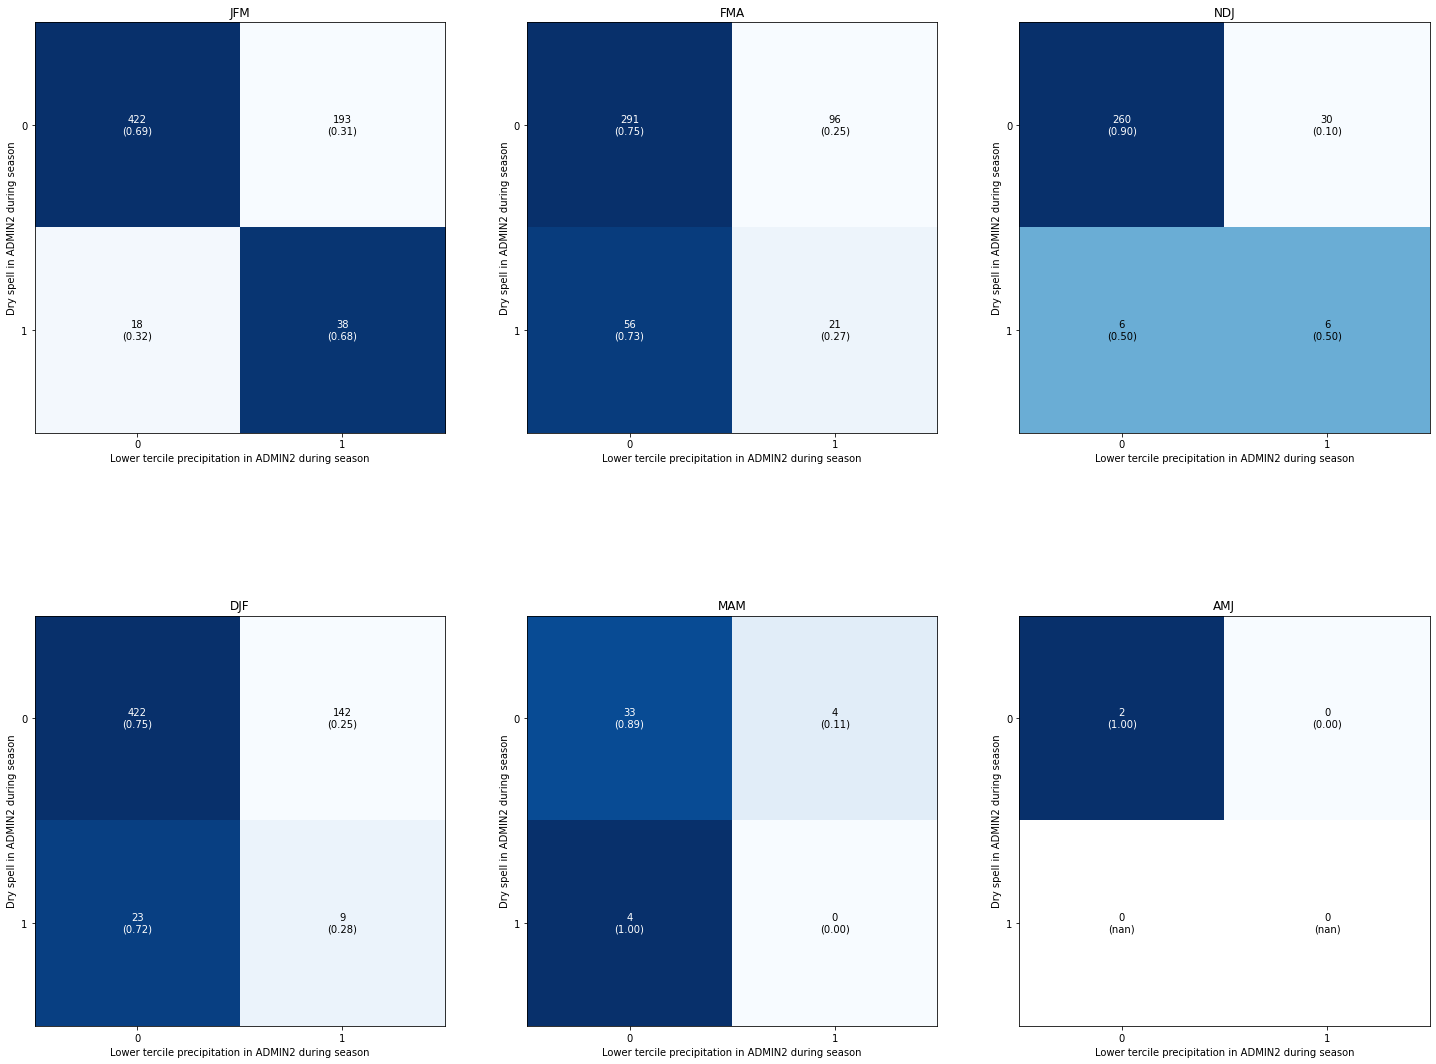

In [81]:
#check if difference per season
colp_num=3
num_plots=len(df_comb_seas.date_month.dt.month.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,m in enumerate(df_comb_seas.sort_values(by="date_month").date_month.dt.month.unique()):
    y_target =    df_comb_seas.loc[df_comb_seas.date_month.dt.month==m,"dry_spell"]
    y_predicted = df_comb_seas.loc[df_comb_seas.date_month.dt.month==m,"below_average"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    ax = fig.add_subplot(rows,colp_num,i+1)
    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax)
    ax.set_ylabel("Dry spell in ADMIN2 during season")
    ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
    ax.set_title(seasons_rolling[m])

### Correlation number of adm2's with dry spells and below avg precip
The data might be too noisy to detect specific adm2's but there might be a correlation when looking at the total of adm2s having a dry spell/below avg precip during season

Conclusion: there is not😥

In [82]:
#number of adm2s experiencing a dry spell/below average
#these don't have to be the same with the current method of computation
df_numadm=df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum()

<ipython-input-82-0b3025a513c2>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_numadm=df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum()


In [83]:
df_numadm

,dry_spell,below_average
date_month,,
2000-03,0,9
2000-04,0,6
2001-01,0,3
2001-02,0,0
2001-03,0,1
...,...,...
2019-05,0,0
2020-01,0,0
2020-02,4,8


<AxesSubplot:xlabel='dry_spell', ylabel='below_average'>

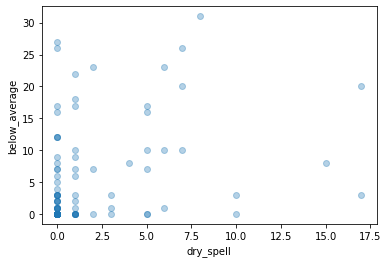

In [84]:
sns.regplot(data = df_numadm, x = 'dry_spell', y = 'below_average', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)

In [85]:
#do the same but per adm1 instead of national
df_nummonthadm=df_comb_seas.groupby(["date_month","ADM1_EN"],as_index=False)[["dry_spell","below_average"]].sum()

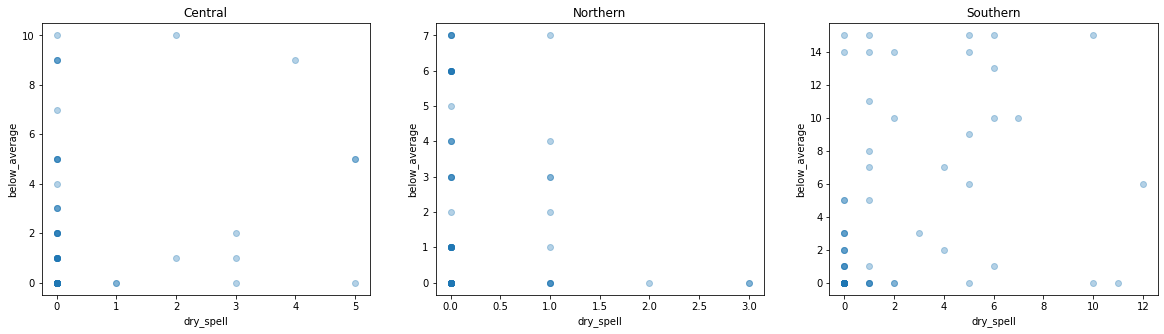

In [86]:
colp_num=3
num_plots=len(df_comb_seas.ADM1_EN.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(20,5))
for i,a in enumerate(df_nummonthadm.ADM1_EN.unique()):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.regplot(data = df_nummonthadm[df_nummonthadm.ADM1_EN==a], x = 'dry_spell', y = 'below_average', fit_reg = False,
            scatter_kws = {'alpha' : 1/3},ax=ax)
    ax.axes.set_title(a)
#     plt.show()

### Distributions below average and dry spells
Understand a little better why no correlation number of adm2's with below average and dry spell

In [87]:
df_comb_seas["year"]=df_comb_seas.date_month.dt.year

<ipython-input-87-07b3f58b3c50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_seas["year"]=df_comb_seas.date_month.dt.year


In [88]:
#for now focus on FMA since this is the season having most dry spels
df_fma=df_comb_seas[df_comb_seas.date_month.dt.month==4]

In [89]:
df_fma_bavgy=df_fma[["ADM1_EN","year","dry_spell","below_average"]].groupby(["year","below_average"],as_index=False).sum()

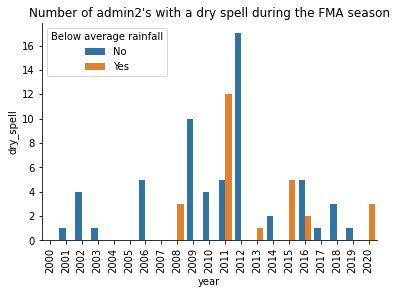

In [42]:
#number of dry spells that did and did not have below avg rainfall per year
df_fma_bavgy['below_average_label'] = df_fma_bavgy['below_average'].map({0: 'No', 1: 'Yes'})
g=sns.barplot(x="year", y="dry_spell", hue="below_average_label", data=df_fma_bavgy)#,legend_out=True)
ax=g.axes
plt.xticks(rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Number of admin2's with a dry spell during the FMA season")
ax.legend(title="Below average rainfall",loc="upper left")

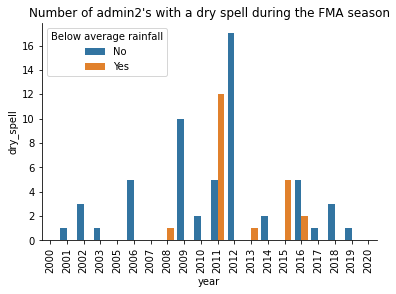

In [90]:
#number of dry spells that did and did not have below avg rainfall per year
df_fma_bavgy['below_average_label'] = df_fma_bavgy['below_average'].map({0: 'No', 1: 'Yes'})
g=sns.barplot(x="year", y="dry_spell", hue="below_average_label", data=df_fma_bavgy)#,legend_out=True)
ax=g.axes
plt.xticks(rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Number of admin2's with a dry spell during the FMA season")
ax.legend(title="Below average rainfall",loc="upper left")

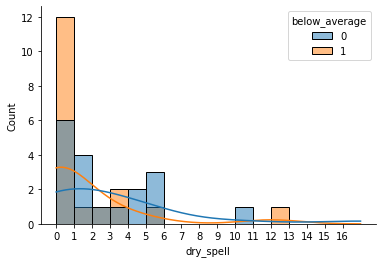

In [43]:
#difference distribution number of dry spells per year, with below and not below avg rainfall
#--> barely difference in distribution
g=sns.histplot(
df_fma_bavgy,x="dry_spell", bins=np.arange(0,df_fma_bavgy.dry_spell.max()),stat="count",hue="below_average",common_norm=False,kde=True) #,hue="below_average"
ax=g.axes
# plt.title(v)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel(v)
ax.set_xticks(np.arange(0,df_fma_bavgy.dry_spell.max()))
plt.show()

In [44]:
#stats summary
df_fma_bavgy["Below average rainfall"]=df_fma_bavgy["below_average_label"]
df_fma_bavgy["Number of dry spells"]=df_fma_bavgy["dry_spell"]
df_fma_bavgy[["Below average rainfall","Number of dry spells"]].groupby("Below average rainfall").agg(['sum','mean','min','max'])

Number of dry spells                  
                                        sum      mean min max
Below average rainfall                                       
No                                       59  3.105263   0  17
Yes                                      26  1.444444   0  12

In [45]:
df_fma_bavgadm=df_fma[["ADM1_EN","year","dry_spell","below_average"]].groupby(["ADM1_EN","year","below_average"],as_index=False).sum()

In [46]:
df_fma_bavgadm

,ADM1_EN,year,below_average,dry_spell
0,Central,2000,0,0
1,Central,2001,0,1
2,Central,2002,0,0
3,Central,2002,1,0
4,Central,2003,0,0
...,...,...,...,...
87,Southern,2017,1,0
88,Southern,2018,0,0
89,Southern,2018,1,0
90,Southern,2019,0,1


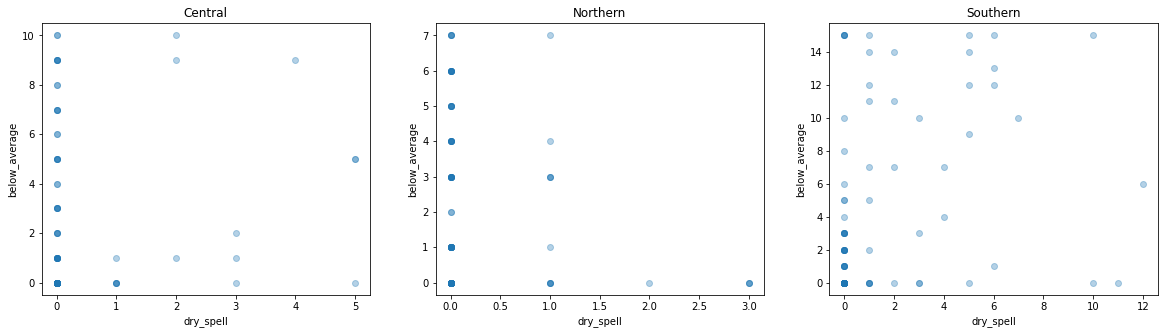

In [47]:
colp_num=3
num_plots=len(df_comb_seas.ADM1_EN.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(20,5))
for i,a in enumerate(df_nummonthadm.ADM1_EN.unique()):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.regplot(data = df_nummonthadm[df_nummonthadm.ADM1_EN==a], x = 'dry_spell', y = 'below_average', fit_reg = False,
            scatter_kws = {'alpha' : 1/3},ax=ax)
    ax.axes.set_title(a)
#     plt.show()

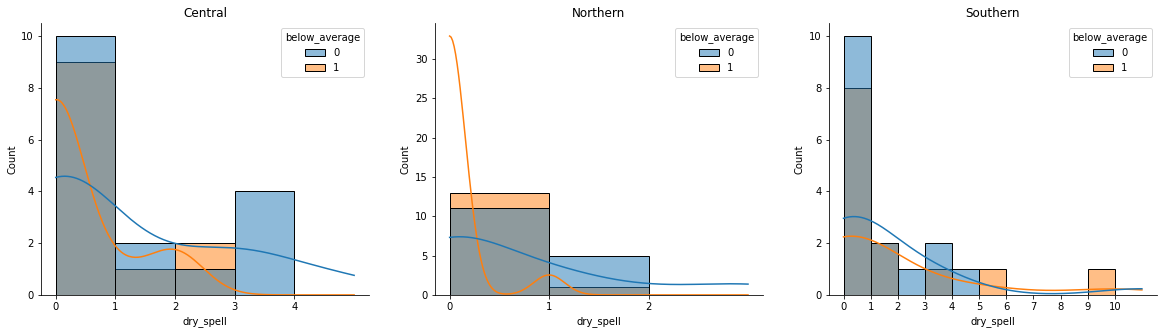

In [48]:
colp_num=3
num_plots=len(df_fma_bavgadm.ADM1_EN.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(20,5))
for i,a in enumerate(df_fma_bavgadm.ADM1_EN.unique()):
    ax = fig.add_subplot(rows,colp_num,i+1)
    g=sns.histplot(
    df_fma_bavgadm[df_fma_bavgadm.ADM1_EN==a],x="dry_spell",ax=ax,bins=np.arange(0,df_fma_bavgadm[df_fma_bavgadm.ADM1_EN==a].dry_spell.max()),stat="count",hue="below_average",common_norm=False,kde=True) #,hue="below_average"
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(np.arange(0,df_fma_bavgadm[df_fma_bavgadm.ADM1_EN==a].dry_spell.max()))
    ax.set_title(a)

In [49]:
##Attempt to check for differences per adm2
# boo=df_fma[["ADM1_EN","ADM2_EN","year","dry_spell","below_average"]].groupby(["ADM2_EN","below_average","year"],as_index=False).sum()
# boo[["ADM2_EN","below_average","dry_spell"]].groupby(["ADM2_EN","below_average"]).agg(['sum','mean','min','max'])

In [50]:
# #not really informative, so leave out
# #select only entries with below average rainfall
# df_fma_bavg=df_fma[df_fma.below_average==1]
# df_fma_bavg_admy=df_fma_bavg[["ADM1_EN","year","dry_spell"]].groupby(["ADM1_EN","year"],as_index=False).sum()
# #very little adm2s where there was below avg rainfall when there was a dry spell
# g=sns.barplot(x="year", y="dry_spell", hue="ADM1_EN", data=df_fma_bavg_admy)
# ax=g.axes
# plt.xticks(rotation=90)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_title("Number of admin2's with below average rainfall that also had a dry spell")

### THIS IS OLD, DONT LOOK AT IT, WILL BE APPROX SAME AS FOR SEASONAL
### Observed dryspells and correlation with below average monthly rainfall
**note: the list of dry spells used here is preliminary, thus the correlations will likely change but the processing should be the same**
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with below-average monthly and seasonal rainfall

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

Questions
- Does it make sense to use the datae of dry spell confirmation, or more logical to use the start date?

In [51]:
df_ds_drymonth

,ds_fd_m,ADM2_EN,dry_spell_first_date
0,2001-04,Ntchisi,1
1,2002-02,Nsanje,1
2,2002-03,Blantyre City,1
3,2002-03,Mulanje,1
4,2002-04,Nkhata Bay,1
...,...,...,...
126,2020-02,Blantyre City,1
127,2020-02,Chiradzulu,1
128,2020-02,Mulanje,1
129,2020-03,Chikwawa,1


In [52]:
df_belowavg_month=pd.read_csv(os.path.join(country_data_processed_dir,"observed_belowavg_precip","chirps_monthly_below_average_precipitation.csv"))
df_belowavg_month.date_month=pd.to_datetime(df_belowavg_month.date_month).dt.to_period("M")

In [53]:
#df_belowavg_seas only includes data from 2000, so the 1999 entries are not included
#remove the adm2-date entries outside the rainy season for that specific adm2
#before we included all forecasts within the min start of the rainy season and max end across the whole country
# total_days=0
list_hist_rain_adm2=[]
for a in df_rain_filled.ADM2_EN.unique():
    dates_adm2=pd.Index([])
    for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
        df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
        seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="M")
        dates_adm2=dates_adm2.union(seas_range)
    list_hist_rain_adm2.append(df_belowavg_month[(df_belowavg_month.ADM2_EN==a)&(df_belowavg_seas.date_month.isin(dates_adm2))])
df_belowavg_month_rain=pd.concat(list_hist_rain_adm2)

In [54]:
#merge the dry spells with the info if a month had below average rainfall
#merge on outer such that all dates present in one of the two are included
df_comb=df_ds_drymonth.merge(df_belowavg_month_rain,how="outer",left_on=["ds_fd_m","ADM2_EN"],right_on=["date_month","ADM2_EN"])

In [55]:
df_comb.head()

,ds_fd_m,ADM2_EN,dry_spell_first_date,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,validTo,perc_threshold,perc_threshold_touched,max_cell_touched,max_cell,below_average_touched,below_average_max,date_str,date_month,below_average
0,2001-04,Ntchisi,1.0,2.085826,0.143596,MW203,NaN,NaN,NaN,Central,...,NaN,29.310345,34.146341,62.404381,62.404381,1,1,2001-04,2001-04,0
1,2002-02,Nsanje,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,NaN,62.121212,54.545455,174.907089,174.907089,1,1,2002-02,2002-02,1
2,2002-03,Blantyre City,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2002-03,2002-03,0
3,2002-03,Mulanje,1.0,2.677536,0.168737,MW308,NaN,NaN,NaN,Southern,...,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2002-03,2002-03,0
4,2002-04,Nkhata Bay,1.0,3.985252,0.345984,MW103,NaN,NaN,NaN,Northern,...,NaN,29.104478,32.795699,182.247345,182.247345,1,1,2002-04,2002-04,0


In [56]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_comb.dry_spell_first_date=df_comb.dry_spell_first_date.replace(np.nan,0)

[[2872 1190]
 [  82   49]]


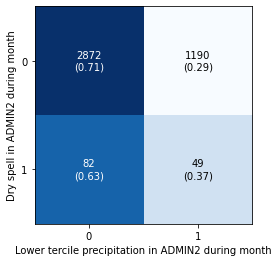

In [57]:
#contigency matrix rainfall and dry spells for all months
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb["dry_spell_first_date"]
y_predicted = df_comb["below_average"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during month")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during month")
plt.show()